In [1]:
import csv
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"

def_font_size = 16

matplotlib.rcParams['font.size'] = def_font_size=16

In [2]:
from weight_shared_analyzer import WeightSharedRun, plot_pareto_curves_ws, get_pareto_curves_df
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
smallest_subnet = {"d":0, "e": 0.1}
middle_1_subnet = {"d":1, "e": 0.2}
middle_2_subnet = {"d":1, "e": 0.5}
largest_subnet = {"d":2, "e": 1.0}
pareto_front_repr = [smallest_subnet, middle_1_subnet, middle_2_subnet, largest_subnet]
pareto_mapping = {f"{smallest_subnet}": 0.017952,  f"{middle_1_subnet}": 0.042576, f"{middle_2_subnet}": 0.09744, f"{largest_subnet}" : 0.258}
subnet_ordering = [0.017952, 0.042576, 0.09744, 0.258]

In [4]:
def max_per_seed(seeds, uptil_r, mode="avg", fedavg=True):
    best_accs = []
    for s in seeds:
        cur_s = WeightSharedRun(s, pareto_front_repr, pareto_mapping)
        if fedavg:
            cur_best_acc, _ = get_pareto_curves_df([cur_s], "Test/{model}/PPL", larger_is_better=False, uptil_round=uptil_r, axis=0)
            best_accs.append(cur_best_acc[0])
            #print("curbestacc: ", cur_best_acc, type(cur_best_acc), cur_best_acc[0])
        else:
            cur_best_acc, _ = get_pareto_curves_df([cur_s], "Test/{model}/PPL", larger_is_better=False, uptil_round=uptil_r, rename=True, mode=mode)
            cur_list = []
            for order in subnet_ordering:
                cur_list.append(cur_best_acc.at[order, cur_best_acc.columns[0]])
                #print("curbestacc: ", order, cur_best_acc.at[order, cur_best_acc.columns[0]], type(cur_best_acc.at[order, cur_best_acc.columns[0]]))
            best_accs.append(cur_list)
    return best_accs

In [5]:
def fedavgCurves_dep(smallest, middle1, middle2, largest):
    fedavg_smallest = WeightSharedRun(smallest, pareto_front_repr, pareto_mapping)
    fedavg_middle_1 = WeightSharedRun(middle1, pareto_front_repr, pareto_mapping)
    fedavg_middle_2 = WeightSharedRun(middle2, pareto_front_repr, pareto_mapping)
    fedavg_largest = WeightSharedRun(largest, pareto_front_repr, pareto_mapping)

    print(fedavg_smallest.name)
    print(fedavg_smallest.df["round"].max())

    print(fedavg_middle_1.name)
    print(fedavg_middle_1.df["round"].max())

    print(fedavg_middle_2.name)
    print(fedavg_middle_2.df["round"].max())

    print(fedavg_largest.name)
    print(fedavg_largest.df["round"].max())
    return [fedavg_smallest, fedavg_middle_1, fedavg_middle_2, fedavg_largest]

def fedavgCurves(smallest, middle1, middle2, largest, uptil_r=1500):
    smallest = max_per_seed(smallest, uptil_r)
    middle1 = max_per_seed(middle1, uptil_r)
    middle2 = max_per_seed(middle2, uptil_r)
    largest = max_per_seed(largest, uptil_r)
    return [smallest, middle1, middle2, largest]

In [6]:
def fed_paretos_internal(fedavg_runs, name="iFedAvg"):
    avg_acc = []
    std_acc = []
    for run in fedavg_runs:
        avg_acc.append(np.mean(run))
        std_acc.append(np.std(run))
    fed_pareto = pd.Series(data=avg_acc, index=subnet_ordering, name=name)
    error_fed_pareto = pd.Series(data=std_acc, index=subnet_ordering, name=name)
    return fed_pareto, error_fed_pareto

def ws_paretos_internal(seeds, rnum, name="SuperFed", mode="avg"):
    print(f"{name} pareto generation running...")
    ws = max_per_seed(seeds, rnum, mode=mode, fedavg=False)
    avg_acc = np.mean(ws, axis=0)
    std_acc = np.std(ws, axis=0)
    ws_pareto = pd.Series(data=avg_acc, index=subnet_ordering, name=name)
    error_ws_pareto = pd.Series(data=std_acc, index=subnet_ordering, name=name)
    return ws_pareto, error_ws_pareto

def fed_paretos(smallest, middle1, middle2, largest, uptil_r=1500, name="iFedAvg"):
    print("fed pareto generation running...")
    return fed_paretos_internal(fedavgCurves(smallest, middle1, middle2, largest, uptil_r), name)

def ws_paretos(ws_runs, rnum, names, mode="avg", modify_names=None):
    ws_concat_list = []
    error_ws_concat_list = []
    for ws_run, name in zip(ws_runs, names):
        cur_pareto, cur_error_pareto = ws_paretos_internal(ws_run, rnum, name=name, mode=mode)
        if modify_names is not None and name in modify_names.keys():
            with open(modify_names[name], newline='') as csvfile:
                csvReader = csv.reader(csvfile, delimiter=' ')
                for row in csvReader:
                    cur_pareto[float(row[0])] = float(row[1])
                    cur_error_pareto[float(row[0])] = float(row[2])
            cur_pareto.sort_index(inplace=True)
            cur_error_pareto.sort_index(inplace=True)
        ws_concat_list.append(cur_pareto)
        error_ws_concat_list.append(cur_error_pareto)
    return pd.concat(ws_concat_list, axis=1), pd.concat(error_ws_concat_list, axis=1)

In [7]:
markersize_def = 8
def adv_plot(fed_pareto, error_fed_pareto, ws_pareto, error_ws_pareto, ax_fill_list, ylim_1, ylim_2, 
             rnum, save_name, xlim_1=0.3, xlim_2=3.5, mode="avg", exclude_fedavg=False, colors=None,
            leg_font_size=def_font_size, ncol=1, leg_ordering=None, markers=None):
    matplotlib.style.use("seaborn-whitegrid")
    if not exclude_fedavg:
        final_df = pd.concat([fed_pareto, ws_pareto], axis=1)
        final_error_df = pd.concat([error_fed_pareto, error_ws_pareto], axis=1)
    else:
        final_df = pd.concat([ws_pareto], axis=1)
        final_error_df = pd.concat([error_ws_pareto], axis=1)
    if colors is not None:
        ax = None
        for i, (col, ax_fill, color) in enumerate(zip(final_df.columns, ax_fill_list, colors)):
            cur_col = final_df.loc[:, [col]]
            cur_col.dropna(inplace=True)
            ax = cur_col.plot.line(marker='o' if markers is None else markers[i], color=color, ax=ax, markersize=markersize_def)
            cur_error_col = final_error_df.loc[:, [col]]
            cur_error_col.dropna(inplace=True)
            ax.fill_between(cur_col.index, cur_col[ax_fill[0]] - cur_error_col[ax_fill[0]], cur_col[ax_fill[0]] + cur_error_col[ax_fill[0]], alpha=ax_fill[1], color=color)
    else:
        ax = None
        for i, (col, ax_fill) in enumerate(zip(final_df.columns, ax_fill_list)):
            cur_col = final_df.loc[:, [col]]
            cur_col.dropna(inplace=True)
            ax = cur_col.plot.line(marker='o' if markers is None else markers[i], ax=ax, markersize=markersize_def)
            cur_error_col = final_error_df.loc[:, [col]]
            cur_error_col.dropna(inplace=True)
            ax.fill_between(cur_col.index, cur_col[ax_fill[0]] - cur_error_col[ax_fill[0]], cur_col[ax_fill[0]] + cur_error_col[ax_fill[0]], alpha=ax_fill[1])
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.xlabel("GFLOPs")
    plt.xlim(xlim_1,xlim_2) # have uniform x-axis accross all plots
    plt.ylim(ylim_1,ylim_2) # have uniform y-axis accross all plots
    plt.ylabel("Test Accuracy")
    plt.tight_layout()
    if leg_ordering is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend([handles[idx] for idx in leg_ordering],[labels[idx] for idx in leg_ordering], loc=4, ncol=ncol, prop={'size':leg_font_size})
    else:
        plt.legend(loc=4, ncol=ncol, prop={'size':leg_font_size})
    plt.savefig(save_name)
    #return final_df, final_error_df

In [8]:
fedavg_runs = fedavgCurves_dep(["flofa/ptb/6190qzi9"],
                          ["flofa/ptb/3gccqo8f"],
                           ["flofa/ptb/1vrh2jel"],
                           ["flofa/ptb/kluzmcu1"],
                          )

20cli-FedAvg-smallest-subnet
109.0
20cli-FedAvg-small-subnet
109.0
20cli-FedAvg-middle-subnet
109.0
20cli-FedAvg-largest-subnet
109.0


In [9]:
maxnet = WeightSharedRun(["flofa/ptb/2ykp8qbv", "flofa/ptb/19jyb52d", "flofa/ptb/2vx2pxq4"], pareto_front_repr, pareto_mapping, name="MaxNet (SuperFed)")
print(maxnet.name)
print(maxnet.df["round"].max())

MaxNet (SuperFed)
200.0


0.017952    148.506565
0.042576    133.932652
0.097440    125.541589
0.258000    123.659956
Name: iFedAvg, dtype: float64
0.017952    0.0
0.042576    0.0
0.097440    0.0
0.258000    0.0
Name: iFedAvg, dtype: float64
          MaxNet (SuperFed)
0.097440         127.280722
0.017952         147.854302
0.042576         133.576415
0.258000         122.676077
          MaxNet (SuperFed)
0.097440           0.662931
0.017952           0.594543
0.042576           0.646030
0.258000           0.333580


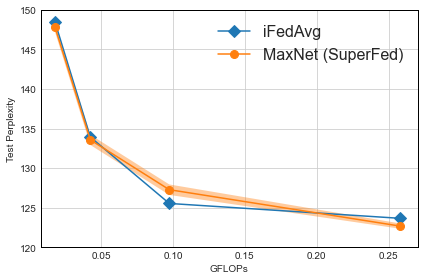

In [17]:
matplotlib.style.use("seaborn-whitegrid")
markersize_def = 8
ws_runs = [maxnet]
ax_fill_list = [["iFedAvg", 0.3], 
                ["MaxNet (SuperFed)", 0.4]]
markers=['D', 'o']
mode="avg"
fed_pareto, error_fed_pareto = get_pareto_curves_df(fedavg_runs, "Test/{model}/PPL", larger_is_better=False, uptil_round=100, rename=True, axis=0, name="iFedAvg")
print(fed_pareto)
print(error_fed_pareto)
ws_pareto, error_ws_pareto = get_pareto_curves_df(ws_runs,  "Test/{model}/PPL", larger_is_better=False, uptil_round=105, rename=True, mode=mode)
print(ws_pareto)
print(error_ws_pareto)

final_df = pd.concat([fed_pareto, ws_pareto], axis=1).loc[subnet_ordering]
final_error_df = pd.concat([error_fed_pareto, error_ws_pareto], axis=1).loc[subnet_ordering]
#     ax = final_df.plot.line(yerr=final_error_df, marker='o')
ax = None
for i, (col, ax_fill) in enumerate(zip(final_df.columns, ax_fill_list)):
    cur_col = final_df.loc[:, [col]]
    cur_col.dropna(inplace=True)
    ax = cur_col.plot.line(marker='o' if markers is None else markers[i], ax=ax, markersize=markersize_def)
    cur_error_col = final_error_df.loc[:, [col]]
    cur_error_col.dropna(inplace=True)
    ax.fill_between(cur_col.index, cur_col[ax_fill[0]] - cur_error_col[ax_fill[0]], cur_col[ax_fill[0]] + cur_error_col[ax_fill[0]], alpha=ax_fill[1])

#ax = final_df.plot.line(marker='o')
#     print(final_df.index)
#     print(final_df["SuperFed"] - final_error_df["SuperFed"])
#ax.fill_between(final_df.index, final_df["iFedAvg"] - final_error_df["iFedAvg"], final_df["iFedAvg"] + final_error_df["iFedAvg"], alpha=0.3)
#ax.fill_between(final_df.index, final_df["SuperFed"] - final_error_df["SuperFed"], final_df["SuperFed"] + final_error_df["SuperFed"], alpha=0.4)
for spine in ax.spines.values():
        spine.set_edgecolor('black')
plt.xlabel("GFLOPs")
plt.xlim(0.008,0.27) # have uniform x-axis accross all plots
plt.ylim(120,150) # have uniform y-axis accross all plots
plt.ylabel("Test Perplexity")
plt.tight_layout()
plt.legend(loc=1, ncol=1, prop={'size':16})
plt.savefig("ptb_homogeneous.pdf")

In [11]:
maxnetOrig = WeightSharedRun(["flofa/ptb/2iqfdwg6", "flofa/ptb/355snv63", "flofa/ptb/2j1pwpxf"], pareto_front_repr, pareto_mapping, name="SuperFedOrig")
print(maxnetOrig.name)
print(maxnetOrig.df["round"].max())
maxnet0_7 = WeightSharedRun(["flofa/ptb/14g4nl4k", "flofa/ptb/1zin8vfv", "flofa/ptb/3vyldi04"], pareto_front_repr, pareto_mapping, name="SuperFed0.7")
print(maxnet0_7.name)
print(maxnet0_7.df["round"].max())


SuperFedOrig
200.0
SuperFed0.7
200.0


0.017952    148.506565
0.042576    133.932652
0.097440    125.541589
0.258000    123.659956
Name: iFedAvg, dtype: float64
0.017952    0.0
0.042576    0.0
0.097440    0.0
0.258000    0.0
Name: iFedAvg, dtype: float64
          MaxNet (SuperFed)  SuperFedOrig  SuperFed0.7
0.097440         127.280722    127.541425   127.795855
0.017952         147.854302    149.574083   147.917132
0.042576         133.576415    134.515679   133.835265
0.258000         122.676077    122.537007   123.606231
          MaxNet (SuperFed)  SuperFedOrig  SuperFed0.7
0.097440           0.662931      0.651447     0.531305
0.017952           0.594543      0.575601     0.219757
0.042576           0.646030      0.360334     0.614786
0.258000           0.333580      0.406571     0.411422


KeyError: 'SuperFed'

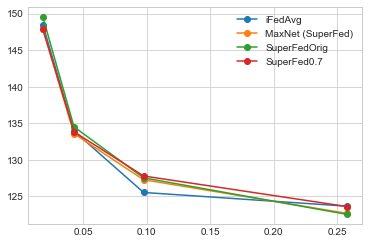

In [16]:
matplotlib.style.use("seaborn-whitegrid")
ws_runs = [maxnet, maxnetOrig, maxnet0_7]

mode="avg"
fed_pareto, error_fed_pareto = get_pareto_curves_df(fedavg_runs, "Test/{model}/PPL", larger_is_better=False, uptil_round=100, rename=True, axis=0, name="iFedAvg")
print(fed_pareto)
print(error_fed_pareto)
ws_pareto, error_ws_pareto = get_pareto_curves_df(ws_runs,  "Test/{model}/PPL", larger_is_better=False, uptil_round=105, rename=True, mode=mode)
print(ws_pareto)
print(error_ws_pareto)
final_df = pd.concat([fed_pareto, ws_pareto], axis=1).loc[subnet_ordering]
final_error_df = pd.concat([error_fed_pareto, error_ws_pareto], axis=1).loc[subnet_ordering]
#     ax = final_df.plot.line(yerr=final_error_df, marker='o')
ax = final_df.plot.line(marker='o')
#     print(final_df.index)
#     print(final_df["SuperFed"] - final_error_df["SuperFed"])
ax.fill_between(final_df.index, final_df["iFedAvg"] - final_error_df["iFedAvg"], final_df["iFedAvg"] + final_error_df["iFedAvg"], alpha=0.3)
ax.fill_between(final_df.index, final_df["SuperFed"] - final_error_df["SuperFed"], final_df["SuperFed"] + final_error_df["SuperFed"], alpha=0.4)
for spine in ax.spines.values():
        spine.set_edgecolor('black')
plt.xlabel("GFLOPs")
plt.xlim(0.008,0.27) # have uniform x-axis accross all plots
plt.ylim(120,150) # have uniform y-axis accross all plots
plt.ylabel("Test Perplexity")
plt.tight_layout()
plt.legend(loc=1)
plt.savefig("ptb_homogeneous_test.pdf")